In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [4]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __neg__(self):
        return self * -1
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now" 
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad = (other * self.data**(other - 1)) * out.grad
        out._backward = _backward

        return out 
    
    def __truediv__(self, other):
        return self * other**-1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - out.data**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
    
    def backward(self):
        topo = []
        visited = set()
        # This is calling _backwards for all nodes, in a topological order
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0

        for node in reversed(topo):
            node._backward()
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [5]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

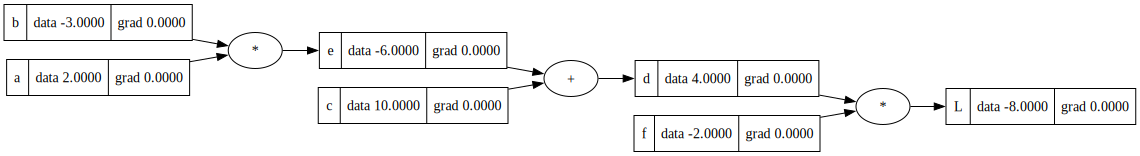

In [6]:
draw_dot(L)

In [7]:
def back_prop_example():
    """Used for gradient check"""
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    return (L2 - L1)/h

back_prop_example()

6.000000000021544

### L = d * f

dL/dd = f

dL/df = d

In [8]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0

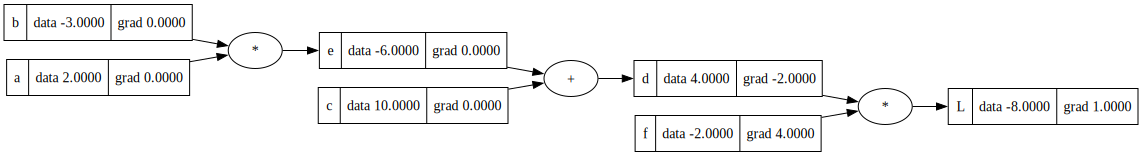

In [9]:
draw_dot(L)

## Chain Rule

### Local derivative

d = c + e

dd / dc = ? ---> 1

dd / de = ? ---> 1

### Global derivative

L = f * (c + e)

dL / dc = ? ---> f

dL / de = ? ---> f

In [10]:
c.grad = -2.0
e.grad = -2.0

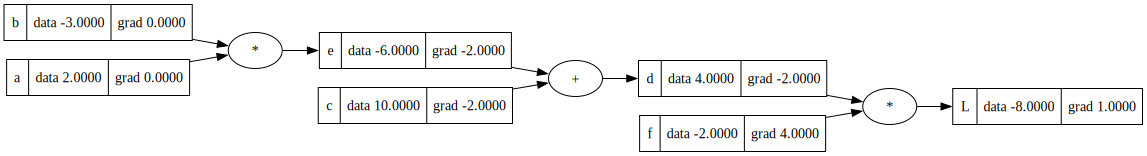

In [11]:
draw_dot(L)

### Local derivative

e = a * b

de / da = ? ---> b

de / db = ? ---> a

### Global derivative

dL / da = f * 1 * b

dL / db = f * 1 * a

In [12]:
a.grad = f.data * b.data
b.grad = f.data * a.data

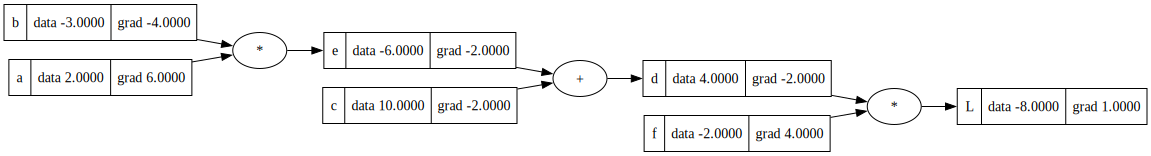

In [13]:
draw_dot(L)

#### **Back-propagation** is just the application of the **Chain Rule**

To make L increase, we just need to go in the direction of the gradient

In [14]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# Run the forward pass
e = a * b
d = e + c
L = d * f
L

Value(data=-7.286496)

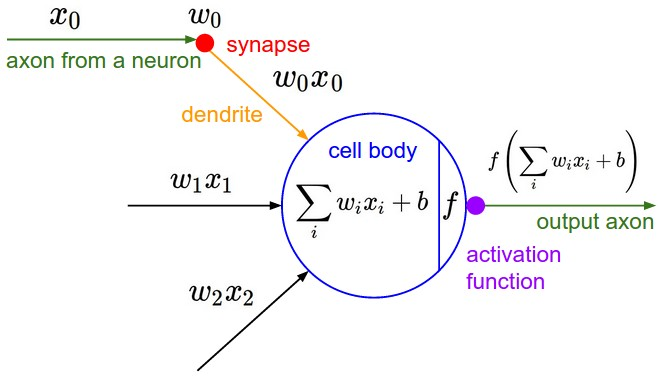

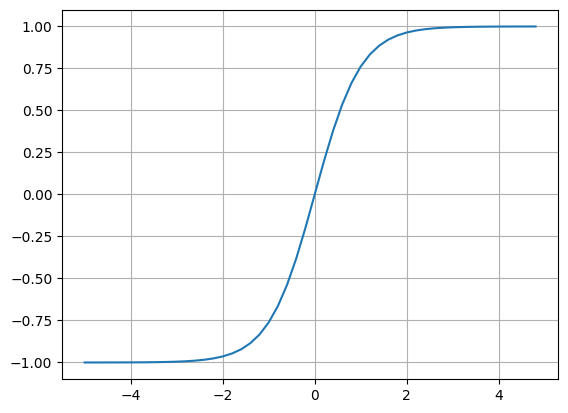

In [15]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

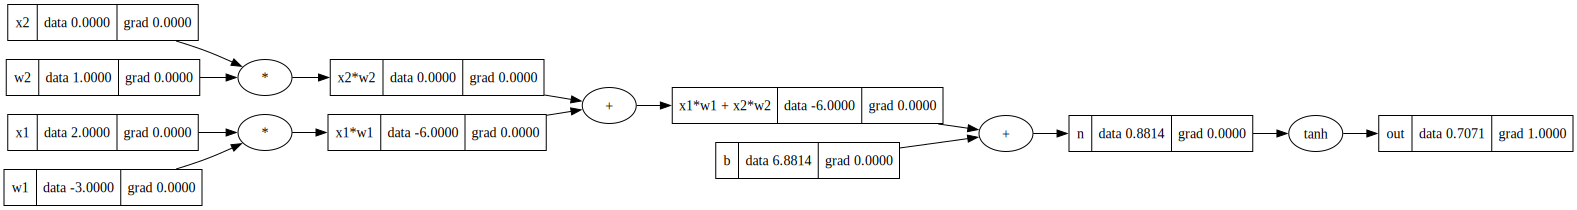

In [16]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b') # This value is for didatic porpouse

# x1*w1 + x2w2 + b
# Doing it in steps to have pointers to the intermediates
x1w1 = x1*w1;  x1w1.label='x1*w1'
x2w2 = x2*w2;  x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n' # cell body, without the activation function

out = n.tanh(); out.label='out'
out.grad = 1.0

draw_dot(out)

out = tanh(n)

dout / dn  = 1 - tanh(n)**2

dout / dn  = 1 - out**2


In [17]:
n.grad = 1 - out.data**2
n.grad

0.4999999999999999

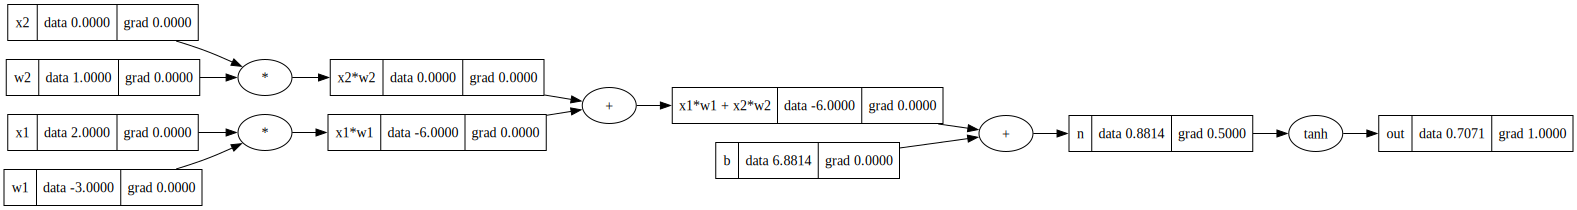

In [18]:
draw_dot(out)

In [19]:
# As "+" is just a distributor os gradient
x1w1x2w2.grad = n.grad
b.grad = n.grad

x1w1.grad = n.grad
x2w2.grad = n.grad

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

... implements _backward for operations

then, redefine Values!

check if out.grad = 1.0

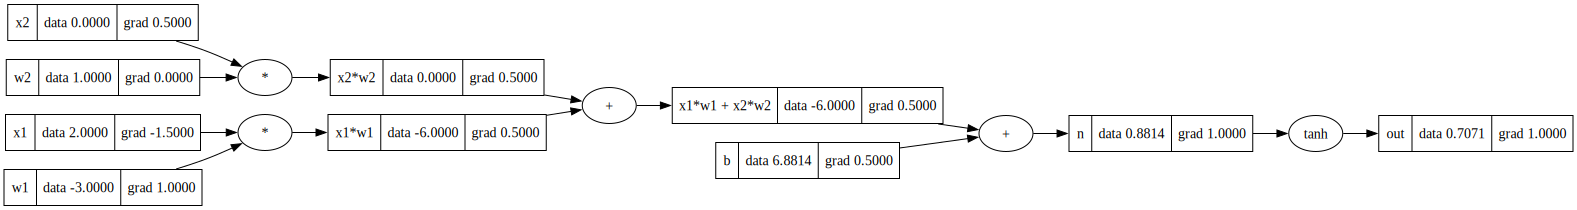

In [20]:
out._backward()
draw_dot(out)

In [21]:
# Topological search

topo = []
visited = set()

# This is calling _backwards for all nodes, in a topological order
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(out)

topo

[Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

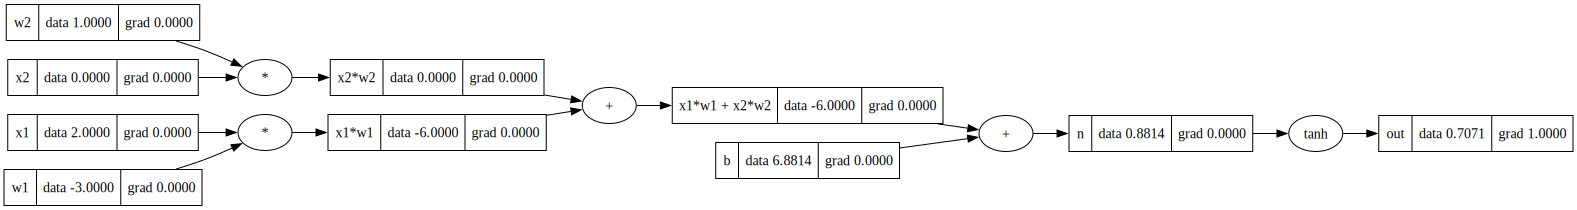

In [22]:
# Proving..
# Reset grads

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b') # This value is for didatic porpouse

# x1*w1 + x2w2 + b
# Doing it in steps to have pointers to the intermediates
x1w1 = x1*w1;  x1w1.label='x1*w1'
x2w2 = x2*w2;  x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n' # cell body, without the activation function

out = n.tanh(); out.label='out'
out.grad = 1.0

draw_dot(out)

In [23]:
topo

[Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

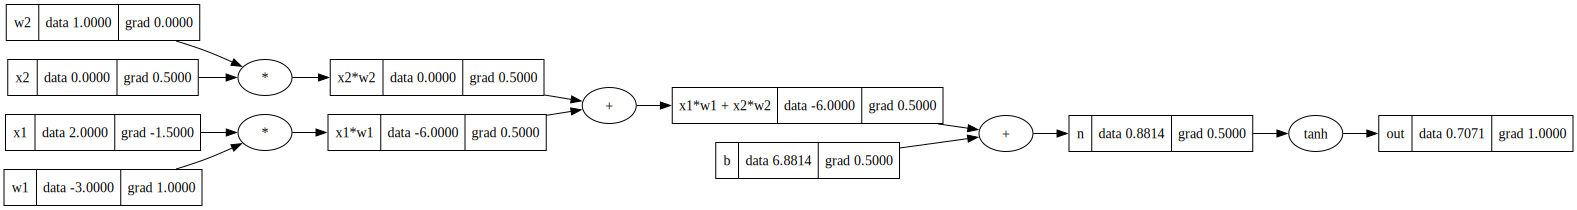

In [24]:
topo = []
visited = set()

build_topo(out)

for node in reversed(topo):
     node._backward()
     
draw_dot(out)

defining backaward in the class

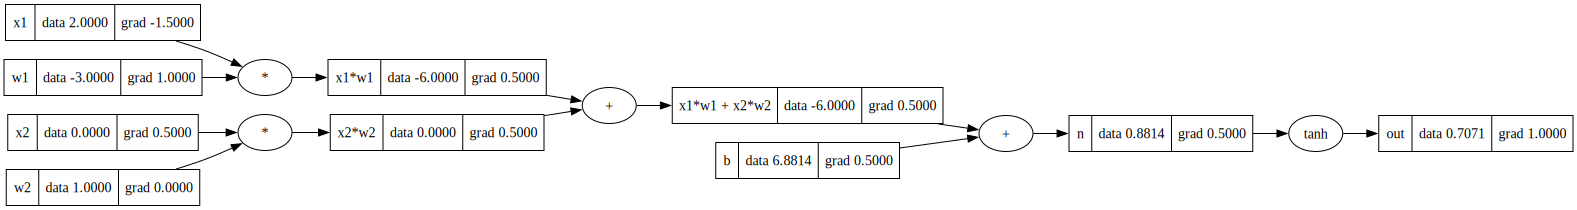

In [25]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b') # This value is for didatic porpouse

# x1*w1 + x2w2 + b
# Doing it in steps to have pointers to the intermediates
x1w1 = x1*w1;  x1w1.label='x1*w1'
x2w2 = x2*w2;  x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n' # cell body, without the activation function

out = n.tanh(); out.label='out'
out.grad = 1.0

# Just call backward on out
out.backward()

draw_dot(out)

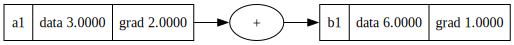

In [26]:
# Correcting a bug
# Adding '+=' to the grad prop

a1 = Value(3.0, label='a1')
b1 = a1 + a1; b1.label='b1'
b1.backward()
draw_dot(b1)

Implementing operations with Value

In [27]:
a = Value(2.0)
b = Value(4.0)

a / b

Value(data=0.5)

In [28]:
a - b

Value(data=-2.0)

In [29]:
import torch

x1 = torch.Tensor([2.0]).double()   ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()   ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()  ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()   ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()
print('-----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
-----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [30]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
    
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Value(data=-0.9885998619202004),
 Value(data=-0.9758091725501766),
 Value(data=0.3717178821769589)]

In [31]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.07509937198743717)

In [30]:
len(n.parameters()), n.parameters()

(41,
 [Value(data=0.5931636389891826),
  Value(data=0.22611153604376732),
  Value(data=-0.8692129560277069),
  Value(data=0.45869670058180145),
  Value(data=0.09289659933275107),
  Value(data=-0.43974540694797937),
  Value(data=0.6529987083079265),
  Value(data=-0.8184574648484735),
  Value(data=0.12854329434676837),
  Value(data=0.06399740374456142),
  Value(data=-0.12033374358903526),
  Value(data=0.5425630233845948),
  Value(data=-0.8780007577852245),
  Value(data=-0.8449920557995398),
  Value(data=0.21404307235383668),
  Value(data=0.8883642983734603),
  Value(data=-0.45955321073130606),
  Value(data=0.8689273006435838),
  Value(data=0.5804189330497882),
  Value(data=0.8647912501712698),
  Value(data=0.6129484082131389),
  Value(data=0.7468768063123925),
  Value(data=-0.4491197954740216),
  Value(data=0.39723092172308094),
  Value(data=-0.6749348276910891),
  Value(data=0.5064513968954765),
  Value(data=-0.5988177962315031),
  Value(data=0.28635072558429053),
  Value(data=-0.386681

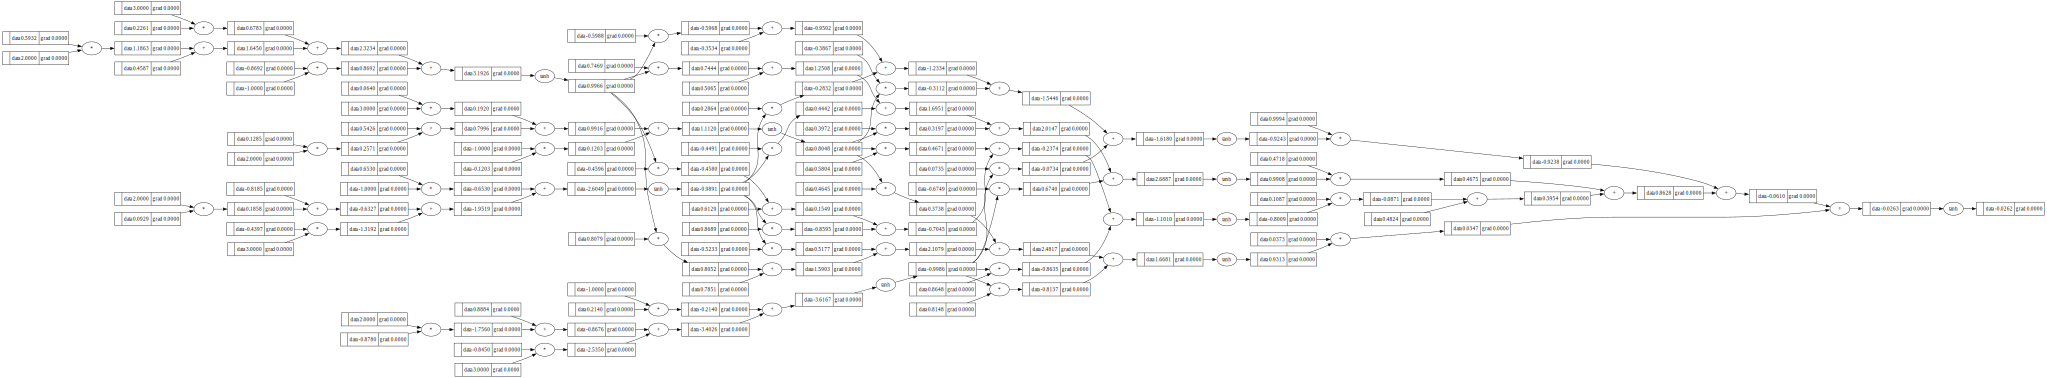

In [31]:
draw_dot(n(x))

In [32]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


Learn cicle --

In [338]:
ypred = [n(x) for x in xs] # forward pass
ypred

[Value(data=0.9999804364083021),
 Value(data=-0.9998952148215344),
 Value(data=-0.9998582240640762),
 Value(data=0.999935594101149)]

In [339]:
# "Loss" individualy
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]

[Value(data=3.8273412012048266e-10),
 Value(data=1.0979933626061728e-08),
 Value(data=2.0100416007067618e-08),
 Value(data=4.148119806810235e-09)]

In [340]:
# Loss 
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=3.5611203560060066e-08)

In [341]:
# Calculates de gradients
loss.backward()

In [342]:
n.layers[0].neurons[0].w[0].grad

-0.815198429384863

In [343]:
n.layers[0].neurons[0].w[0].data

0.795243002486362

In [344]:
# Update data
for p in n.parameters():
    p.data += -0.001 * p.grad

In [309]:
n.layers[0].neurons[0].w[0].data

0.7919822086294191

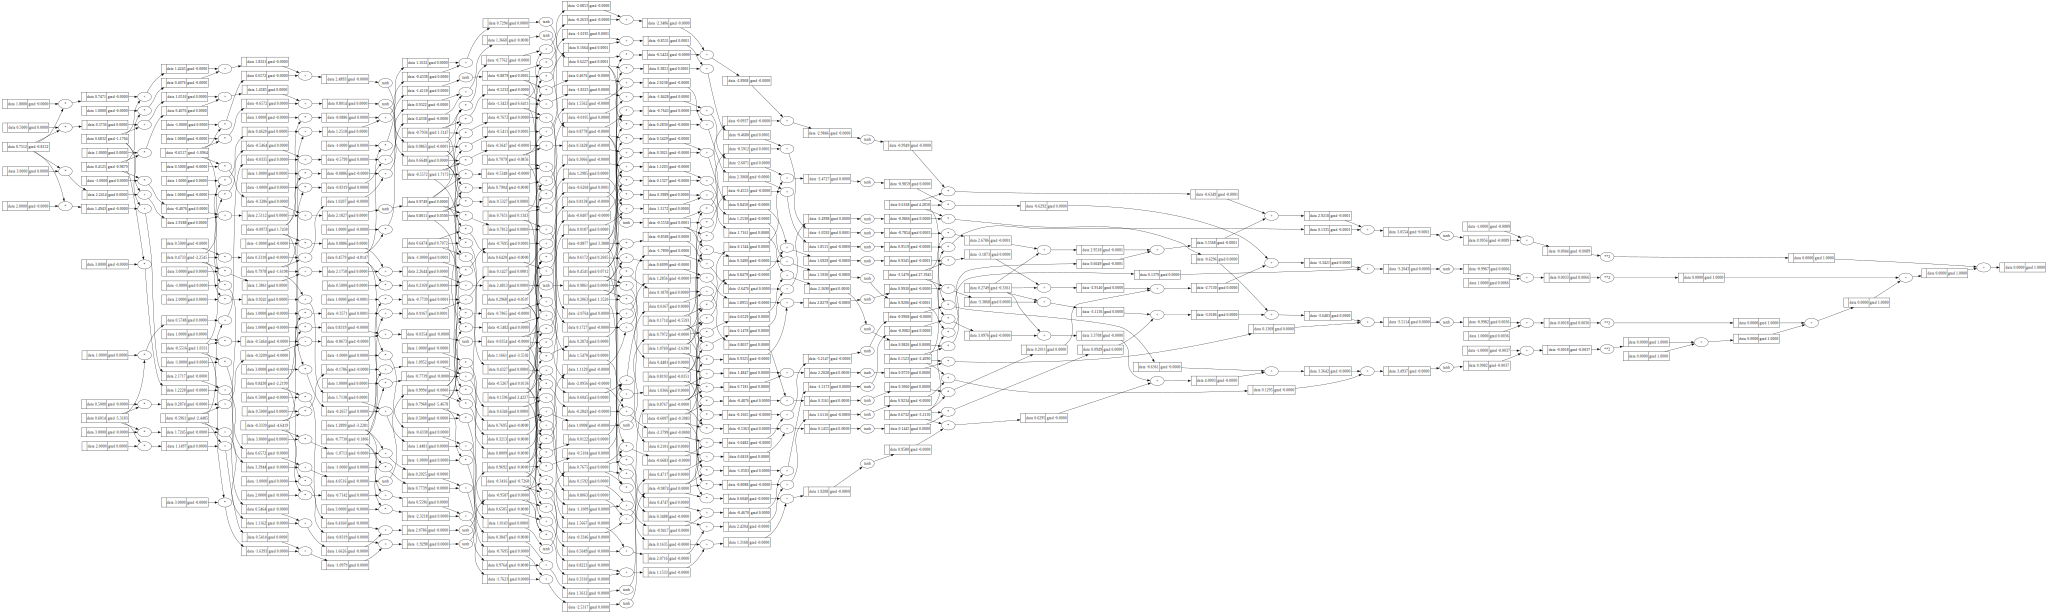

In [214]:
draw_dot(loss)

In [33]:
# Build neural network
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.3423390127118466)

In [34]:
# Data
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [35]:
# Train loop
for k in range(20):

    # Forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # Calculates de gradients, backward pass
    for p in n.parameters(): # Avoid bug, by flushing gradients, because they add up "+="
        p.grad = 0.0
    loss.backward()

    # Update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 5.302527953149904
1 3.3576305689754675
2 2.839395859264248
3 2.4572279433757473
4 2.0104097810454675
5 1.2973071060913277
6 0.7088947740596642
7 0.4642724283391508
8 0.3425635285336487
9 0.2697784767206686
10 0.2213022271788238
11 0.18675036078427093
12 0.16093434692362768
13 0.14095858377325243
14 0.12507625561304508
15 0.11217046940951972
16 0.10149398125524911
17 0.09252827644416133
18 0.08490255659569948
19 0.07834485300713201
